In [3]:
from pathlib import Path

# 1) Auto-detect your repo root by searching for a ".git" folder upwards from the notebook
here = Path.cwd()
repo_root = next((p for p in [here, *here.parents] if (p / ".git").exists()), here)

# 2) Build robust absolute paths from the repo root
root_path   = repo_root / "data" / "rapidsim" / "Lb_LcDst0K_tree.root"
weights_par = repo_root / "data" / "rapidsim" / "Lb_LcDst0K_w_mLcK.parquet"

print("Notebook cwd       :", here)
print("Detected repo root :", repo_root)
print("ROOT file path     :", root_path)
print("Weights parquet    :", weights_par)

# Sanity checks
assert root_path.exists(), f"ROOT file not found at: {root_path}"
assert weights_par.exists(), f"Parquet file not found at: {weights_par}"


Notebook cwd       : /home/lhcbvilnius/work/lb-lcDstarK/notebooks
Detected repo root : /home/lhcbvilnius/work/lb-lcDstarK
ROOT file path     : /home/lhcbvilnius/work/lb-lcDstarK/data/rapidsim/Lb_LcDst0K_tree.root
Weights parquet    : /home/lhcbvilnius/work/lb-lcDstarK/data/rapidsim/Lb_LcDst0K_w_mLcK.parquet


In [10]:
import uproot

# Helper: find a TTree no matter its name (default is often "DecayTree")
def get_first_ttree(file):
    keys = file.keys()
    # Try common name first
    if "DecayTree" in keys:
        return file["DecayTree"], "DecayTree"
    # Otherwise, pick the first TTree-looking key
    for k in keys:
        try:
            obj = file[k]
            # uproot 5: TTree objects have .num_entries attribute
            _ = obj.num_entries  # will raise if not a TTree
            return obj, k
        except Exception:
            continue
    raise RuntimeError(f"No TTree found. Keys: {keys}")

with uproot.open(root_path) as f:
    tree, treename = get_first_ttree(f)
    print("Opened ROOT file. TTree name:", treename)
    # Peek at the available branches so you can verify names
    print("Branch sample:", tree.keys()[:20])


Opened ROOT file. TTree name: DecayTree;3
Branch sample: ['nEvent', 'Lb0_0_M', 'Lb0_0_M_TRUE', 'Lb0_0_P', 'Lb0_0_P_TRUE', 'Lb0_0_PT', 'Lb0_0_PT_TRUE', 'Lambda_cp_0_P', 'Lambda_cp_0_P_TRUE', 'Dst0_0_P', 'Dst0_0_P_TRUE', 'Km_0_P', 'Km_0_P_TRUE', 'Lambda_cp_0_PT', 'Lambda_cp_0_PT_TRUE', 'Dst0_0_PT', 'Dst0_0_PT_TRUE', 'Km_0_PT', 'Km_0_PT_TRUE', 'Lambda_cp_0_Dst0_0_M']


entries: 147343
weight stats: min= 0.2961872038830513 max= 1.0 mean= 0.5126093837386583


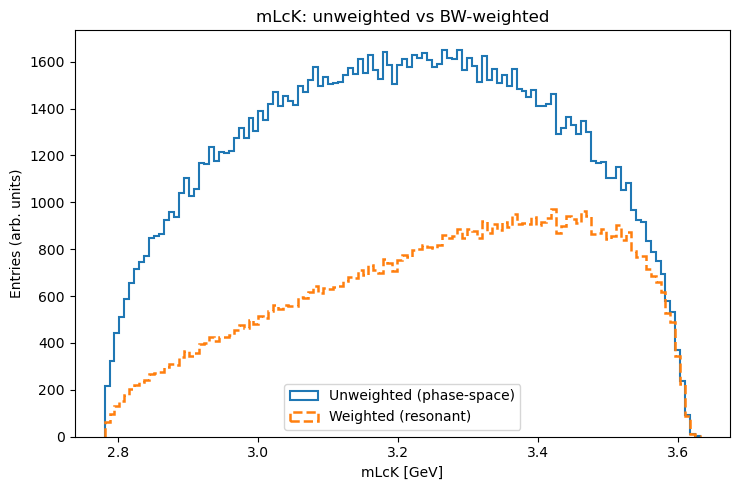

saved: /home/lhcbvilnius/work/lb-lcDstarK/figures/mass_mLcK_unw_vs_weighted.png


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mass_branch = "mLcK"  # change if you weighted a different pair

# Load mass branch
m = tree[mass_branch].array(library="np")  # GeV
n_events = len(m)
print("entries:", n_events)

# Load weights parquet
wdf = pd.read_parquet(weights_par)
assert {"event","weight"} <= set(wdf.columns), "Parquet must have 'event' and 'weight'."
assert wdf["event"].max() < n_events, "Weight index exceeds number of ROOT entries."
assert wdf["event"].min() >= 0, "Negative event index found."

# Build aligned weight array
w = np.zeros(n_events, dtype=np.float64)
w[wdf["event"].to_numpy()] = wdf["weight"].to_numpy()
print("weight stats: min=", w.min(), "max=", w.max(), "mean=", w.mean())

# Binning window
m_min, m_max = float(np.min(m)), float(np.max(m))
bins = np.linspace(m_min, m_max, 121)

# Plot unweighted vs weighted
plt.figure(figsize=(7.5,5.0))
plt.hist(m, bins=bins, histtype="step", linewidth=1.5, label="Unweighted (phase-space)")
plt.hist(m, bins=bins, weights=w, histtype="step", linewidth=1.8, linestyle="--", label="Weighted (resonant)")
plt.xlabel(f"{mass_branch} [GeV]"); plt.ylabel("Entries (arb. units)")
plt.title(f"{mass_branch}: unweighted vs BW-weighted")
plt.legend(); plt.tight_layout()

out_png = repo_root / "figures" / f"mass_{mass_branch}_unw_vs_weighted.png"
plt.savefig(out_png, dpi=160)
plt.show()
print("saved:", out_png)
